# Определение стоимости автомобилей

Сервису по продаже автомобилей с пробегом «Не бит, не крашен» необходимро разработать приложение, чтобы привлечь новых клиентов, в нём можно будет узнать рыночную стоимость своего автомобиля. 
Построим модель, которая умеет её определять по данным о технических характеристиках и параметрах автомобилей.

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import ydata_profiling

from datetime import datetime, date

from matplotlib import pyplot as plt

from catboost import CatBoostRegressor, Pool


from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

from time import perf_counter 

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

Посмотрим на имеющиеся данные

In [3]:
try:
    df = pd.read_csv('datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')
df.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

In [4]:
ydata_profiling.ProfileReport(df) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Основные проблемы текущего датасета:
1. 4 строки датасета продублированы.
1. Столбец Price - целевой признак, 3% значений нули.
1. Столбец VehicleType - пропущено 10.6% значений.
1. Столбец RegistrationYear - встречаются аномальные значения, минимальный год - 1000, максимальный - 9999.
1. Столбец Столбец RegistrationMonth - 10.5% значений нули.
1. Столбец Gearbox - пропущено 5.6% значений.
1. Столбец Power - 11.4% значений нули, встречаются аномальные значения вплоть до 20 000 л.с.
1. Столбец Model - пропущено 5.6% значений.
1. Столбец FuelType - пропущено 9.3% значений, имеются неявные дубликаты значений(petrol и gasoline, cng и lng).
1. Столбец Repaired - пропущено 20.1% значений.
1. Столбец NumberOfPictures - ВСЕ значения нулевые.

На тепловой карте датасета можно заметить, что целевой признак имеет корреляцию с мощностью автомобиля и годом его выпуска, а также обратную корреляцию с пробегом, что говорит о том, что данные в целом адекватные.



In [5]:
df = df.drop_duplicates(keep='first')

In [6]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df.DateCrawled.max().year

2016

In [7]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df.DateCreated.max().year

2016

Данные в датасете ограничены 2016-м годом, учтём это в дальнейшей работе.

Избавимся от неинформативных признаков.

In [8]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

В датасете значительное количество пропусков в столбцах 'VehicleType', 'Gearbox', 'FuelType', для некоторых моделей есть только один вариант комплектации по этим признакам, найдём такие модели и заполним пропуски имеющимися значениями.

In [9]:
criteria = ['VehicleType', 'Gearbox', 'FuelType']
for criterion in criteria:
    for vehicle in df.Model.unique():
        if len(df.loc[(df.Model == vehicle) & (df[criterion].notna()), criterion].unique()) == 1:
            df.loc[(df.Model == vehicle) & (df[criterion].isna()), criterion] = \
            df.loc[(df.Model == vehicle) & (df[criterion].notna()), criterion].unique()[0]

In [10]:
df.isna().sum()

Price                    0
VehicleType          37428
RegistrationYear         0
Gearbox              19755
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32737
Brand                    0
Repaired             71154
dtype: int64

Таких пропусков оказалось не много, заполним остальные пропуски строкой 'unspecified'.

In [11]:
criteria = ['VehicleType', 'Gearbox', 'FuelType', 'Model', 'Repaired']

In [12]:
for criterion in criteria:
    df.loc[df[criterion].isna(), criterion] = 'unspecified'

In [13]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [14]:
df.FuelType.unique()

array(['petrol', 'gasoline', 'unspecified', 'lpg', 'other', 'hybrid',
       'cng', 'electric'], dtype=object)

В стобце 'FuelType' есть неявные дубликаты значений, заменим их.

In [15]:
df.loc[df.FuelType == 'gasoline', 'FuelType'] = 'petrol'
df.loc[df.FuelType == 'cng', 'FuelType'] = 'lpg'
df.loc[df.FuelType == 'other', 'FuelType'] = 'unspecified'

In [16]:
df.FuelType.unique()

array(['petrol', 'unspecified', 'lpg', 'hybrid', 'electric'], dtype=object)

In [17]:
df[df.RegistrationYear > 2016]

Price  VehicleType  RegistrationYear      Gearbox  Power    Model  \
22       2900  unspecified              2018       manual     90   meriva   
26       5555  unspecified              2017       manual    125       c4   
48       7750  unspecified              2017       manual     80     golf   
51       2000  unspecified              2017       manual     90    punto   
57       2399  unspecified              2018       manual     64    other   
...       ...          ...               ...          ...    ...      ...   
354112   3600  unspecified              2017       manual     86  transit   
354140   1000  unspecified              2017       manual    101       a4   
354203   2140  unspecified              2018       manual     80   fiesta   
354253   1250  unspecified              2018  unspecified      0    corsa   
354289   5000  unspecified              2017       manual    120    other   

        Kilometer  RegistrationMonth     FuelType       Brand     Repaired  
22         150000                  5       petrol        opel           no  
26         125000                  4  unspecified     citroen           no  
48         100000                  1       petrol  volkswagen  unspecified  
51         150000                 11       petrol        fiat          yes  
57         125000                  3  unspecified        seat           no  
...           ...                ...          ...         ...          ...  
354112     150000                  5       petrol        ford  unspecified  
354140     150000                  9  unspecified        audi  unspecified  
354203     150000                  6  unspecified        ford           no  
354253     150000                  0       petrol        opel  unspecified  
354289     150000                  7  unspecified     citroen          yes  

[14530 rows x 11 columns]

В значениях 'RegistrationYear' много аномальных значений, избавимся от строк, где значения выше 2016 и тех, что являются статистическими выбросами (опеределение цены ретро-автомобилей - это отдельная задача требующая индивидуального подхода к каждому автомобилю.)

In [18]:
df = df[df.RegistrationYear <= 2016]

In [19]:
def clear_data(data, criterion):
    
    IQR = data[criterion].quantile(0.75) - data[criterion].quantile(0.25)
    
    bottom_threshold = data[criterion].quantile(0.25) - 1.5 * IQR
    if bottom_threshold < 0:
        bottom_threshold = 0
        
    top_threshold = data[criterion].quantile(0.75) + 1.5 * IQR
    
    return data[(data[criterion] > bottom_threshold) & (data[criterion] < top_threshold)]

In [20]:
df = clear_data(df, 'RegistrationYear')

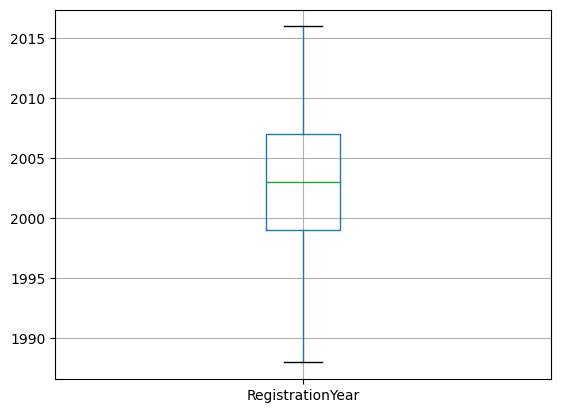

In [21]:
df.boxplot('RegistrationYear');

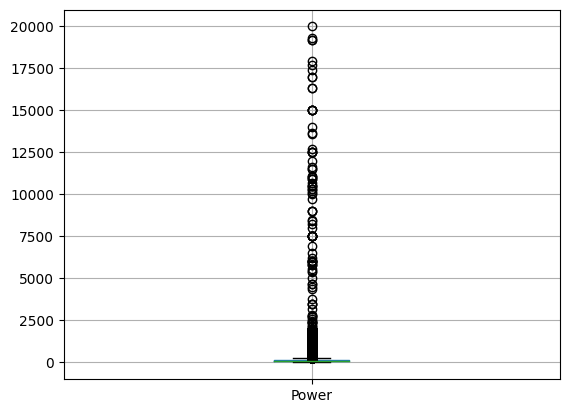

In [22]:
df.boxplot('Power');

Избавимся также от статистических выбросов и нулевых значений в стобце 'Power', заменим значения на медианные.

In [23]:
%%time

for vehicle in df.Model.unique():
    top_threshold = df.loc[df.Model == vehicle, 'Power'].quantile(0.75) + 1.5 *\
    (df.loc[df.Model == vehicle, 'Power'].quantile(0.75) - df.loc[df.Model == vehicle, 'Power'].quantile(0.25))
    
    df.loc[(df.Model == vehicle) & (df['Power'] > top_threshold), 'Power'] = df.loc[df.Model == vehicle, 'Power'].median()
    df.loc[(df.Model == vehicle) & (df['Power'] == 0), 'Power'] = df.loc[df.Model == vehicle, 'Power'].median()

CPU times: user 27.7 s, sys: 0 ns, total: 27.7 s
Wall time: 27.7 s


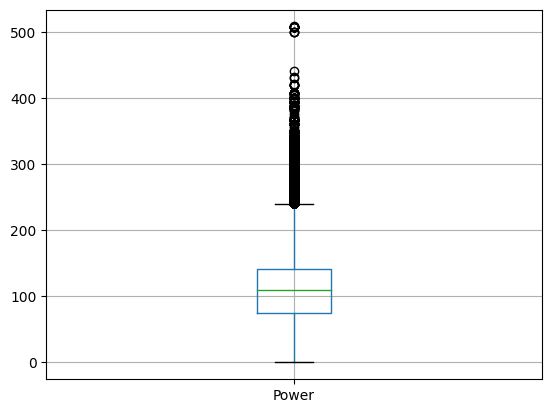

In [24]:
df.boxplot('Power');

In [25]:
df[df.Power == 0]

Price  VehicleType  RegistrationYear Gearbox  Power   Model  \
3338      199  unspecified              1995  manual    0.0  samara   
26625     200  unspecified              2016  manual    0.0  samara   
42665     300        small              1997  manual    0.0  samara   
45401       0        wagon              2007  manual    0.0  samara   
69358      99  unspecified              1995  manual    0.0  samara   
150050    650        wagon              2007  manual    0.0  samara   
353555   2199  unspecified              2016  manual    0.0  samara   

        Kilometer  RegistrationMonth     FuelType Brand     Repaired  
3338       100000                  0       petrol  lada  unspecified  
26625      150000                  0       petrol  lada  unspecified  
42665       50000                  3       petrol  lada          yes  
45401      125000                  8       petrol  lada  unspecified  
69358      125000                  0       petrol  lada  unspecified  
150050     125000                  8       petrol  lada  unspecified  
353555      70000                  0  unspecified  lada           no

После замены значений на медианные, всё же остались несколько нулевых значений, удалим их из датасета.

In [26]:
df = df[df.Power != 0]

Избавимся от нулевых значений и возможных аномалий в целевом признаке, заменим их на медианные значения.

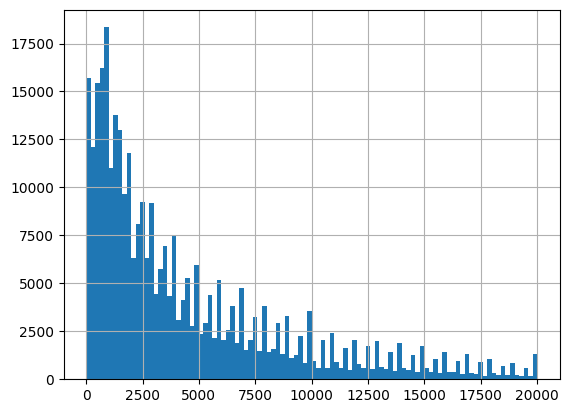

In [27]:
df.Price.hist(bins=100);

In [28]:
%%time

for vehicle in df.Model.unique():
    top_threshold = df.loc[df.Model == vehicle, 'Price'].quantile(0.75) + 1.5 *\
    (df.loc[df.Model == vehicle, 'Price'].quantile(0.75) - df.loc[df.Model == vehicle, 'Price'].quantile(0.25))
    
    df.loc[(df.Model == vehicle) & (df['Price'] > top_threshold), 'Price'] = df.loc[df.Model == vehicle, 'Price'].median()
    df.loc[(df.Model == vehicle) & (df['Price'] == 0), 'Price'] = df.loc[df.Model == vehicle, 'Price'].median()

CPU times: user 28 s, sys: 5.76 ms, total: 28 s
Wall time: 28 s


In [29]:
df[df.Price == 0] 

Empty DataFrame
Columns: [Price, VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, RegistrationMonth, FuelType, Brand, Repaired]
Index: []

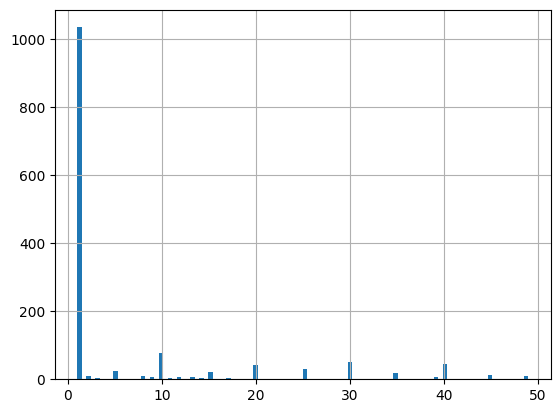

In [30]:
df[df.Price < 50]['Price'].hist(bins=100);

In [31]:
df = df[df.Price > df.Price.quantile(0.005)]

In [32]:
df.RegistrationMonth.unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

В столбце RegistrationMonth есть значения нулевого месяца, т.к. в дальнейшем мы будем рассчитывать возраст автомобиля, то заменим это значение на среднее.  

In [33]:
df.loc[df.RegistrationMonth == 0, 'RegistrationMonth'] = 6

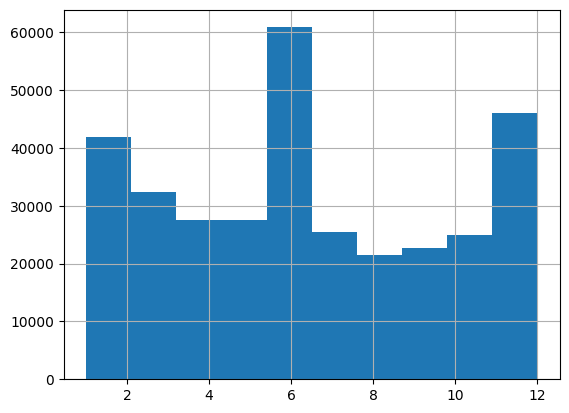

In [34]:
df['RegistrationMonth'].hist();

Преобразуем значения 'RegistrationYear' и 'RegistrationMonth' в зхначения возраста автомобиля и запишем их в отдельный столбец.

In [35]:
df['Registration'] = df['RegistrationYear'].astype('str') + '-' + df['RegistrationMonth'].astype('str')

In [36]:
df['Registration'] = pd.to_datetime(df['Registration'], format='%Y-%M')

In [37]:
df['CarAge'] = (datetime.now() - df['Registration']).astype('<m8[Y]')  

In [38]:
df = df.drop(['Registration', 'RegistrationYear', 'RegistrationMonth'], axis=1)

In [39]:
df.head()

Price  VehicleType Gearbox  Power        Model  Kilometer FuelType  \
0   480.0  unspecified  manual   98.0         golf     150000   petrol   
1  1250.0        coupe  manual  190.0  unspecified     125000   petrol   
2  9800.0          suv    auto  163.0        grand     125000   petrol   
3  1500.0        small  manual   75.0         golf     150000   petrol   
4  3600.0        small  manual   69.0        fabia      90000   petrol   

        Brand     Repaired  CarAge  
0  volkswagen  unspecified    30.0  
1        audi          yes    12.0  
2        jeep  unspecified    19.0  
3  volkswagen           no    22.0  
4       skoda           no    15.0

In [40]:
df.shape

(330669, 10)

In [41]:
ydata_profiling.ProfileReport(df) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

После проведённых замен и преобразований в датасете образовалось 9.9% дубликатов строк, удалим их из датасета.

In [42]:
df = df.drop_duplicates(keep='first')

## Обучение моделей

Обучим несколько моделей для сравнения их адекватности и эффективности.

Чтобы сократить время обучения моделей, примем число разбиения обучающей выборки для кроссвалидации равным 3 (в GridSearchCV и RandomizedSearchCV по умолчанию - 5).

In [43]:
crossval = KFold(n_splits=3, shuffle=True)

Разделим целевые признаки и параметры.

In [44]:
features = df.drop('Price', axis=1)
target = df['Price'] 

Изменим тип стобцов с категориальными параметрами на категориальный.

In [45]:
for col in features.columns:
    if features[col].dtype == 'object':
        features[col] = features[col].astype('category')

Разобьём  данные на обучающую и тестовую выборку.

In [46]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.2)

In [47]:
for frame in [features_train, features_test, target_train, target_test]:
    print(frame.shape)

(223481, 9)
(55871, 9)
(223481,)
(55871,)


In [48]:
ohe_features = features.select_dtypes(include='category').columns.to_list()
ohe_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [49]:
num_features = features.select_dtypes(exclude='category').columns.to_list()
num_features

['Power', 'Kilometer', 'CarAge']

In [50]:
features_train.columns

Index(['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType',
       'Brand', 'Repaired', 'CarAge'],
      dtype='object')

### Ridge

Создадим пайплайн модели и параметры для перебора с помощью GridSearchCV.

In [51]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    #remainder='passthrough',
    verbose_feature_names_out=False
)

In [52]:
ridge_pipe = make_pipeline(col_transformer, Ridge())

ridge_params = {
    'ridge__alpha': np.logspace(-3, 3, 14),
}

ridge_grid = GridSearchCV(
    ridge_pipe, 
    param_grid=ridge_params, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=False
)

In [53]:
%%time
ridge_grid.fit(features_train, target_train)

/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anacon

CPU times: user 8.9 s, sys: 8.3 s, total: 17.2 s
Wall time: 34.1 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'Kilometer',
                                                                          'CarAge'])],
                                                          verbose_feature_names_out=False)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([1.00000000e-03, 2.89426612e-03, 8.37677640e-03, 2.42446202e-02,
       7.01703829e-02, 2.03091762e-01, 5.87801607e-01, 1.70125428e+00,
       4.92388263e+00, 1.42510267e+01, 4.12462638e+01, 1.19377664e+02,
       3.45510729e+02, 1.00000000e+03])},
             scoring='neg_root_mean_squared_error', verbose=False)

### Lasso

Создадим пайплайн модели и параметры для перебора с помощью GridSearchCV.

In [54]:
lasso_pipe = make_pipeline(col_transformer, Lasso())

lasso_params = [{
        'lasso__alpha': [0.02, 0.03]
    } ]

lasso_grid = GridSearchCV(lasso_pipe,
                    param_grid=lasso_params,
                    cv=crossval,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

Обучим модель.

In [55]:
%%time
lasso_grid.fit(features_train, target_train);

/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7466370401.325562, tolerance: 246942487.87277555
  model = cd_fast.sparse_enet_coordinate_descent(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increas

CPU times: user 6min 17s, sys: 3min 54s, total: 10min 11s
Wall time: 7min 25s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'Kilometer',
                                                                          'CarAge'])],
                                                          verbose_feature_names_out=False)),
                                       ('lasso', Lasso())]),
             n_jobs=-1, param_grid=[{'lasso__alpha': [0.02, 0.03]}],
             scoring='neg_root_mean_squared_error', verbose=False)

### ElasticNet()

Создадим пайплайн модели и параметры для перебора с помощью GridSearchCV.

In [56]:
elasticnet = ElasticNet()
elastic_pipe = make_pipeline(col_transformer, elasticnet)


elastic_params = [
    {'elasticnet__alpha': [.0004, .0005],
     'elasticnet__l1_ratio': [0.5, 1]}
]
    
elastic_grid = GridSearchCV(elastic_pipe,
                            param_grid=elastic_params, 
                            cv=crossval,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            verbose=False)

Обучим модель.

In [57]:
%%time
elastic_grid.fit(features_train, target_train)

/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391435949645.14954, tolerance: 247036443.75258037
  model = cd_fast.sparse_enet_coordinate_descent(
/home/romauov/anaconda3/envs/env39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unkn

CPU times: user 8min 14s, sys: 4min 49s, total: 13min 3s
Wall time: 16min 38s


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'Kilometer',
                                                                          'CarAge'])],
                                                          verbose_feature_names_out=False)),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1,
             param_grid=[{'elasticnet__alpha': [0.0004, 0.0005],
                          'elasticnet__l1_ratio': [0.5, 1]}],
             scoring='neg_root_mean_squared_error', verbose=False)

### Light GBM

Создадим модель и параметры для случайного поиска с помощью RandomizedSearchCV.

In [58]:
lgbm_model = lgb.LGBMRegressor(verbose=-1)

lgbm_params = {
    'num_leaves': [31, 41, 51],
    'min_child_samples': [5, 15],
    'max_depth': [10, 20],
    'learning_rate': np.logspace(-3, -1, 3),
    'reg_alpha': np.logspace(-4, -2, 2)
                                           }

lgbm_grid = RandomizedSearchCV(lgbm_model,
                               lgbm_params,
                               cv=crossval,
                               scoring='neg_root_mean_squared_error',
                               n_iter=10)

Обучим модель.

In [59]:
%%time
lgbm_grid.fit(X=features_train, y=target_train)

CPU times: user 1min 29s, sys: 205 ms, total: 1min 30s
Wall time: 24.2 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
                   estimator=LGBMRegressor(verbose=-1),
                   param_distributions={'learning_rate': array([0.001, 0.01 , 0.1  ]),
                                        'max_depth': [10, 20],
                                        'min_child_samples': [5, 15],
                                        'num_leaves': [31, 41, 51],
                                        'reg_alpha': array([0.0001, 0.01  ])},
                   scoring='neg_root_mean_squared_error')

Покажем важность признаков модели.

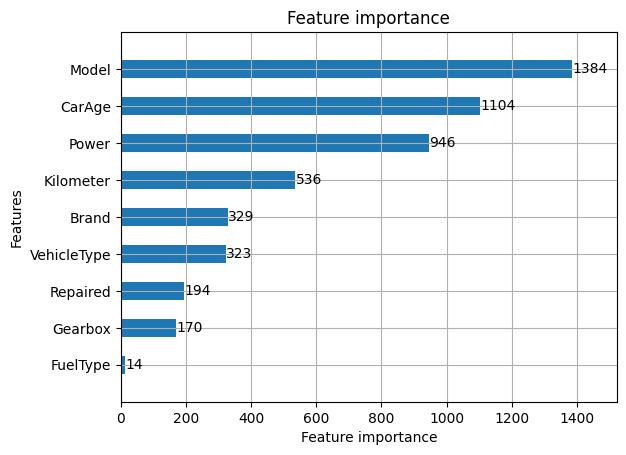

In [60]:
lgb.plot_importance(lgbm_grid.best_estimator_, height=.5);

### CatBoost

Создадим модель и параметры для случайного поиска с помощью RandomizedSearchCV.

In [61]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [62]:
cat_model = CatBoostRegressor(loss_function='RMSE',
                        silent=True,
                        cat_features=cat_features)

cat_params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [d for d in range(2, 11)],
}

cat_grid = RandomizedSearchCV(cat_model,
                        cat_params,
                        cv=crossval,
                               scoring='neg_root_mean_squared_error',
                               n_iter=10)

Обучим модель.

In [63]:
%%time
cat_grid.fit(features_train, target_train);

CPU times: user 3min 25s, sys: 9.15 s, total: 3min 35s
Wall time: 44.3 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f8f5b3a76d0>,
                   param_distributions={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'iterations': [40, 60],
                                        'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
                   scoring='neg_root_mean_squared_error')

Покажем важность признаков модели.

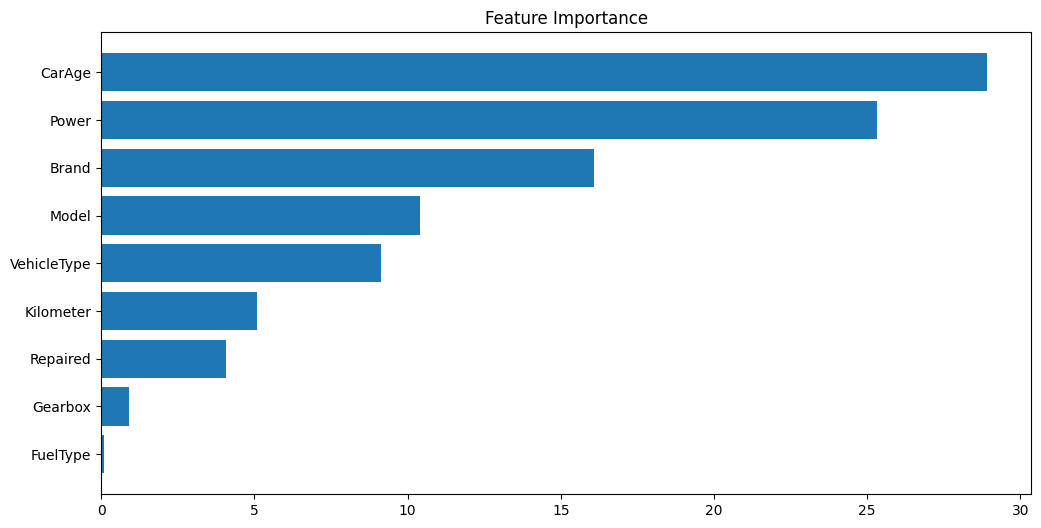

In [64]:
cat_imp = cat_grid.best_estimator_.feature_importances_
sorted_idx = np.argsort(cat_imp)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), cat_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features.columns)[sorted_idx])
plt.title('Feature Importance');

Как видно из графиков модели LightGBM и CatBoost по-разному оценивают влияние параметров на целевые признаки.

## Анализ моделей

Соберём данные моделей в единую таблицу.

In [65]:
grids = [ridge_grid, lasso_grid, elastic_grid, lgbm_grid, cat_grid]

In [66]:
models_data = []
for grid in grids:
    # id модели с лучшими параметрами
    best_id = np.argmin(grid.cv_results_['rank_test_score'])
    models_data.append(
        [
            # лучшее значение метрики RMSE на обучающей выборке
            (-grid.cv_results_['mean_test_score'][best_id]).round(3),
            # время обучения модели
            grid.cv_results_['mean_fit_time'][best_id].round(3),
            # время плучения предсказаний
            grid.cv_results_['mean_score_time'][best_id].round(3)
        ]
    ) 
models_df = pd.DataFrame(data=models_data,
                         index=['Ridge', 'Lasso', 'ElasticNet', 'LightGBM', 'CatBoost'],
                         columns=['лучшее RMSE на обучающей выборке', 'время обучения модели', 'время получения предсказаний']
                        )
display(models_df)

лучшее RMSE на обучающей выборке  время обучения модели  \
Ridge                               2403.425                  4.437   
Lasso                               2403.366                211.918   
ElasticNet                          2404.196                279.357   
LightGBM                            1670.165                  0.577   
CatBoost                            1779.211                  2.202   

            время получения предсказаний  
Ridge                              0.198  
Lasso                              0.166  
ElasticNet                         0.284  
LightGBM                           0.188  
CatBoost                           0.037

Лучший результат в итоге показала модель Light GBM, скорость её обучения также самая высокая.
Посмотрим на результат этой модели на тестовой выборке:

In [67]:
(mean_squared_error(target_test, grid.best_estimator_.predict(features_test)) ** 0.5).round(1)

1764.0

Результат соответствует целевому уровню.

## Выводы по проделанной работе:

1. Был проведён EDA-анализ полученного датасета: были заменены или удалены пропущеннные, нулевые и аномальные значения; удалены неявные названия в значениях параметров; удалены неинформативные признаки; удалены дублирующися строки.
1. Было обучено несколько моделей 'Ridge', 'Lasso', 'ElasticNet', 'LightGBM', 'CatBoost' и для каждой модели были отобраны оптимальные параметры.
1. Данные по моделям с оптимальными параметрами сведены в общую таблицу.
1. RMSE метрика всех полученных моделей соответствует целевому уровню.
1. Для работы рекомендуется использовать модель Light GBM, как самую быструю и точную, со следующими параметрами:

In [68]:
lgbm_grid.best_params_

{'reg_alpha': 0.01,
 'num_leaves': 51,
 'min_child_samples': 5,
 'max_depth': 20,
 'learning_rate': 0.1}